In [9]:
%pip install -r requirements.txt
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, SimpleRNN, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import keras_tuner as kt
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalFocalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau

seed = 42
max_sequence_length = 300
vocabulary_size = 10000

Note: you may need to restart the kernel to use updated packages.


In [10]:
(x_full, y_full), (x_foo, y_foo) = reuters.load_data(test_split=0, seed=seed)
index_by_word = reuters.get_word_index(path="reuters_word_index.json")
word_by_offset_index = {index + 3: word for word, index in index_by_word.items()}
reuters_label_names = reuters.get_label_names()
label_names = [str(i) for i in range(46)]  # 46 total classes
y_full_label_names_decoded = [reuters_label_names[label] for label in y_full]
num_classes = len(label_names)
print(f"Total samples: {len(x_full)}")
print(f"Total classes: {num_classes}")
print(f"Total vocabulary: {len(index_by_word)}")
print(f"Longest Sequence: {max([len(x) for x in x_full])}")
print(f"Shortest Sequence: {min([len(x) for x in x_full])}")
print(f"Average Sequence Length: {np.mean([len(x) for x in x_full])}")
sorted_word_index = sorted(index_by_word.items(), key=lambda x: x[1])
print(f"Top 50 Words: {sorted_word_index[:50]}")
print(f"Bottom 50 Words: {sorted_word_index[-50:]}")
print(f"All Classes: {reuters_label_names}")
print(f"Sample x: {x_full[0]}")
print(f"Sample y: {y_full[0]}")
print(f"Sample x (decoded): {[word_by_offset_index.get(i, '?') for i in x_full[0]]}")
print(f"Sample y (decoded): {reuters_label_names[y_full[0]]}")

Total samples: 11228
Total classes: 46
Total vocabulary: 30979
Longest Sequence: 2376
Shortest Sequence: 2
Average Sequence Length: 145.96419665122906
Top 50 Words: [('the', 1), ('of', 2), ('to', 3), ('in', 4), ('said', 5), ('and', 6), ('a', 7), ('mln', 8), ('3', 9), ('for', 10), ('vs', 11), ('dlrs', 12), ('it', 13), ('reuter', 14), ('000', 15), ('1', 16), ('pct', 17), ('on', 18), ('from', 19), ('is', 20), ('that', 21), ('its', 22), ('cts', 23), ('by', 24), ('at', 25), ('year', 26), ('be', 27), ('with', 28), ('2', 29), ('will', 30), ('was', 31), ('billion', 32), ('he', 33), ('u', 34), ('s', 35), ('net', 36), ('has', 37), ('would', 38), ('an', 39), ('as', 40), ('5', 41), ('not', 42), ('loss', 43), ('4', 44), ('1986', 45), ('company', 46), ('which', 47), ('but', 48), ('this', 49), ('shr', 50)]
Bottom 50 Words: [('teishoku', 30930), ('bbd', 30931), ('grandmarais', 30932), ('enahnce', 30933), ('jerritt', 30934), ('wilq', 30935), ('cogeca', 30936), ('unflappable', 30937), ('cogeco', 30938),

In [11]:
(x_full, y_full), (x_foo, y_foo) = reuters.load_data(num_words=vocabulary_size, skip_top=50, maxlen=max_sequence_length, test_split=0, seed=seed)
x_train, x_temp, y_train, y_temp = train_test_split(
    x_full, y_full, test_size=0.2, random_state=seed, stratify=y_full
)
x_test, x_val, y_test, y_val = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=seed, stratify=y_temp
)

y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

x_train_padded = pad_sequences(x_train, maxlen=max_sequence_length, padding="post")
x_val_padded = pad_sequences(x_val, maxlen=max_sequence_length, padding="post")
x_test_padded = pad_sequences(x_test, maxlen=max_sequence_length, padding="post")

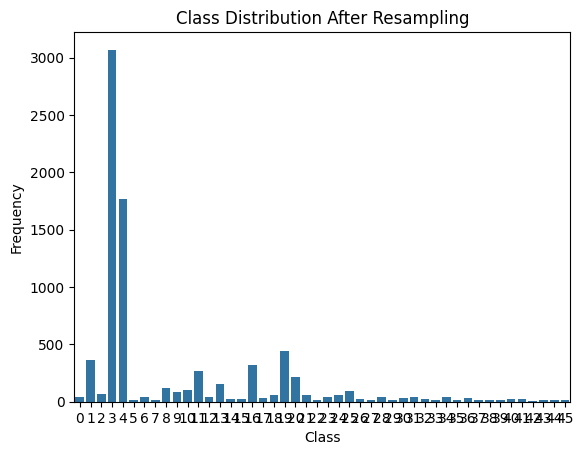

In [12]:
sns.countplot(x=y_train) 
plt.title("Class Distribution After Resampling")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

In [13]:
def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)

    print(classification_report(y_test, y_pred_classes, target_names=reuters_label_names, digits=3))
    

In [14]:
import keras_tuner as kt

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

def build_bilstm_model(hp):
    model = Sequential()
    model.add(
        Embedding(
            input_dim=vocabulary_size,
            output_dim=hp.Choice('embedding_dim', [64, 128, 256]),
            input_length=max_sequence_length
        )
    )
    model.add(
        Bidirectional(
            LSTM(
                hp.Int('lstm_units', min_value=5, max_value=128, step=32),
                return_sequences=False,
                dropout=hp.Float('lstm_dropout', 0.1, 0.5, step=0.1)
            )
        )
    )
    model.add(Dense(
        hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation=hp.Choice('dense_activation', ['relu', 'tanh']),
        kernel_regularizer=l2(hp.Choice('l2_strength', [1e-2, 1e-3, 1e-4])) 
    ))
    model.add(Dropout(hp.Float('dense_dropout', 0.1, 0.5, step=0.1)))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(
        optimizer=AdamW(),
        loss=CategoricalFocalCrossentropy(gamma=hp.Float('gamma', min_value=1.0, max_value=5.0, step=0.5)),
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_bilstm_model,
    objective='val_accuracy',
    max_trials=25,
    directory='reuters_randomsearch',
    project_name='bilstm_focal_tuning',
    overwrite=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

tuner.search(
    x_train_padded, y_train_cat,
    epochs=20,
    validation_data=(x_val_padded, y_val_cat),
    batch_size=16,
    verbose=2,
    callbacks=[early_stopping, reduce_lr]
)

best_model = tuner.get_best_models(num_models=1)[0]

Trial 25 Complete [00h 02m 51s]
val_accuracy: 0.79438316822052

Best val_accuracy So Far: 0.8094282746315002
Total elapsed time: 01h 04m 03s


/home/sagemaker-user/csc-6621-final-project/.conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [15]:
evaluate_model(best_model, x_test_padded, y_test_cat)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
                 precision    recall  f1-score   support

          cocoa      0.667     0.667     0.667         6
          grain      0.712     0.822     0.763        45
        veg-oil      0.778     0.875     0.824         8
           earn      0.910     0.943     0.926       384
            acq      0.852     0.887     0.869       221
          wheat      0.000     0.000     0.000         2
         copper      1.000     0.500     0.667         6
        housing      1.000     1.000     1.000         1
   money-supply      0.571     0.571     0.571        14
         coffee      0.727     0.800     0.762        10
          sugar      1.000     0.714     0.833        14
          trade      0.657     0.697     0.676        33
       reserves      0.600     0.600     0.600         5
           ship      0.647     0.579     0.611        19
         cotton      1.000     0.333     0.500         3
        carcass      1.000     0.333     0.500 

/home/sagemaker-user/csc-6621-final-project/.conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sagemaker-user/csc-6621-final-project/.conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sagemaker-user/csc-6621-final-project/.conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [16]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
for hp in best_hps.values:
    print(f"{hp}: {best_hps.get(hp)}")

Best hyperparameters:
embedding_dim: 256
lstm_units: 32
lstm_dropout: 0.1
dense_units: 64
dense_activation: relu
l2_strength: 0.0001
dense_dropout: 0.4
gamma: 1.5
